# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# LR Transductive workflow

##### Ver:: A2_V6
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl

In [7]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?
sample_data_knn = 0.1 # Apply empirical bayes sampling weighted by knn?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
}

# Transductive workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

In [8]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
if sample_data_knn != False:
    print('Empirical bayes sampling option selected')
    adata_samp, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, feat_use = 'LVL3', knn_key = 'neighbors', sampling_rate= sample_data_knn, iterations=50, replace = True,equal_allocation=True)
print('adata_loaded')

Empirical bayes sampling option selected
You are using an equal allocation mode of sampling, be warned that this can cause errors if the smaller populations are insufficient in number, consider replace == True
You are using sampling with replacement, this allows the model to create clones of cells
adata_loaded


In [98]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)

In [99]:
adata.obs[feat_use].value_counts().sort_index()

AEC                        1707
CMP                          25
Cycling DC2                  81
Def_Erythroid               289
Early_Erythroid             699
Endoderm                   7656
Eo_Baso_Mast_precursor       56
Eo_Basophil                  93
Erythroid                 61038
Fibroblast                28730
HE                          314
HSPC_1                     2158
HSPC_2                      982
ILC_precursor               185
Immature_EC                1486
LMPP                        169
Lymphoid B lin              152
Lymphoid_progenitor         605
MEMP                        762
MK                         2044
MOP                         211
Mac DC2                      60
Macrophage                44413
Mast_cell                   354
Mesothelium                2750
Microglia                   613
Mid_Erythroid               638
Mono Mac DC2                 99
Mono Mac pre DC2             68
Monocyte_0                  200
Monocyte_Macrophage          63
Monocyte

In [115]:
#def empirical_bayes_balanced_stratified_KNN_sampling(adata, feat_use, knn_key, sampling_rate=0.1, iterations=1,representation_priority = 0.5, equal_allocation=False, replace = True, **kwargs):

representation_priority = 0.5
equal_allocation=False

if equal_allocation:
    print('You are using an equal allocation mode of sampling, be warned that this can cause errors if the smaller populations are insufficient in number, consider replace == True')

if replace == True:
    print('You are using sampling with replacement, this allows the model to create clones of cells')

if representation_priority > 0.5:
    print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

# Convert string labels to integer labels
unique_labels, indices = np.unique(adata.obs[feat_use], return_inverse=True)
adata.obs['int.labels'] = indices

# Calculate frequencies (prior probabilities)
label_counts = np.bincount(indices)
frequencies = label_counts / label_counts.sum()

# Create a dictionary where keys are label indices and values are their frequencies (prior probabilities)
prior_distribution = dict(zip(range(len(unique_labels)), frequencies))

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

# Initialize label probabilities with prior distribution
label_probs = prior_distribution.copy()

# Get indices for each label
label_indices = {label: np.where(adata.obs['int.labels'] == label)[0] for label in range(len(unique_labels))}

# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
sample_size_per_label = total_sample_size // len(unique_labels)

sampling_probabilities_over_iterations = np.zeros((iterations, len(unique_labels)))
for _ in range(iterations):
    print('Iteration: {}'.format(_))
    # Stratified sampling within each neighborhood for each label
    all_weights = []
    all_indices = []
    for label in label_indices.keys():
        indices = label_indices[label]
        neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

        same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
        same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

        same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
        different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

        same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
        different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

        # we now compute a hybrid weighting scheme, where cells with more defined neigthborhood structure are prioritised. Howevever we do not want this over penalise, so we recover underrepresented cells with a inverse weighting parameter
        # Calculate the ratio of same-label weights to different-label weights
        # Add a small constant in the denominator to avoid division by zero
        weights = same_label_weights+ 1e-8 / (different_label_weights + 1e-8)
        #update sampling probability with combination weights and observational probs, this adjusts weights by the inverse of sampling probability to increase rare sampling events
        # representation priority 0-1, 0 is no prioritisation for rare-states, 0.9 is maximum priority
        if representation_priority != 0:
            weights *= 1 / (label_probs[label] + 1e-8) *  representation_priority # add a small constant to avoid division by zero
        else:
            weights *= 1 / (label_probs[label] + 1e-8)
        all_weights.extend(weights)
        all_indices.extend(indices)

    all_weights = np.array(all_weights) / np.sum(all_weights)  # normalization to probabilities

    sample_indices = np.random.choice(all_indices, size=total_sample_size, replace=replace, p=all_weights)

    # Update label probabilities based on the observed sample
    sample_labels = adata.obs['int.labels'][sample_indices]
    label_counts = np.bincount(sample_labels, minlength=len(unique_labels))
    label_probs = dict(zip(range(len(unique_labels)), label_counts / label_counts.sum()+1e-8))
    # Store the sampling probabilities for this iteration
    sampling_probabilities_over_iterations[_, :] = np.array(list(label_probs.values())) 

average_sampling_probabilities = sampling_probabilities_over_iterations.mean(axis=0)
updated_label_probs = dict(zip(range(len(unique_labels)), average_sampling_probabilities))

# Final stratified sampling using the last label_probs
label_sample_sizes = {label: int(updated_label_probs[label] * total_sample_size) for label in range(len(unique_labels))}
# Adjust sample sizes so total equals 'total_sample_size'
difference = total_sample_size - sum(label_sample_sizes.values())
label_sample_sizes[0] += difference  # adjust the first label for simplicity
if equal_allocation:
    label_sample_sizes = {label: sample_size_per_label for label in range(len(unique_labels))}
final_sample_indices = []
for label, sample_size in label_sample_sizes.items():
    indices = label_indices[label]
    neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

    same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
    same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

    same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
    different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

    same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
    different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

    # Calculate the ratio of same-label weights to different-label weights
    # Add a small constant in the denominator to avoid division by zero
    weights = same_label_weights / (different_label_weights + 1e-8)

    weights = weights / weights.sum()  # normalization to probabilities
    sampled_indices = np.random.choice(indices, size=sample_size, replace=replace, p=weights)
    final_sample_indices.extend(sampled_indices)
adata_samp = adata[final_sample_indices,:]
#     return adata_samp, final_sample_indices

You are using sampling with replacement, this allows the model to create clones of cells
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


/tmp/ipykernel_16658/383834549.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['int.labels'] = indices
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


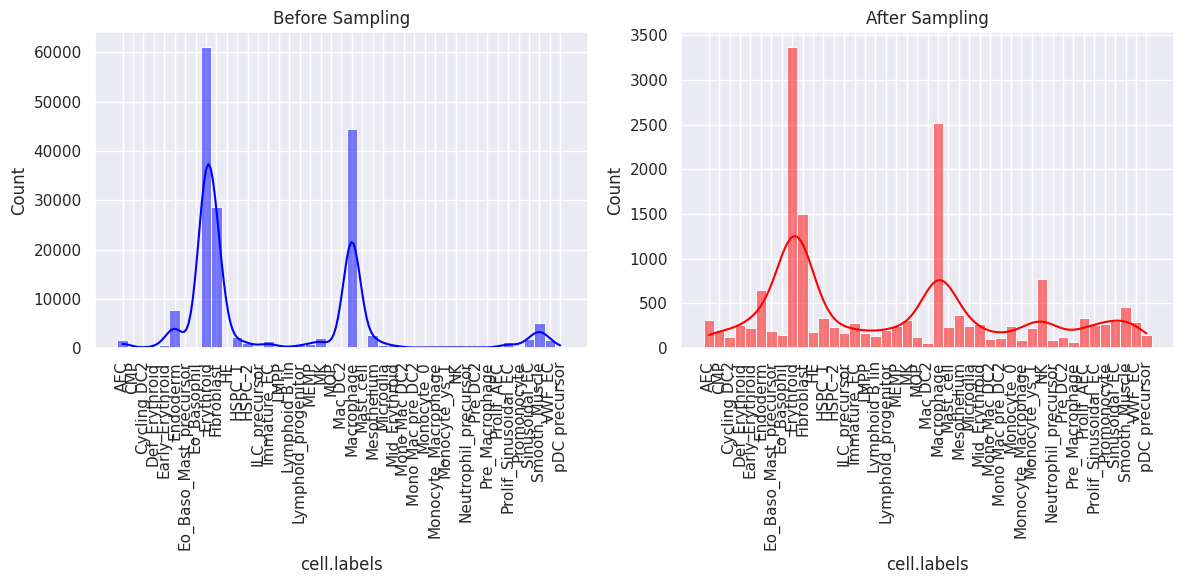

Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.


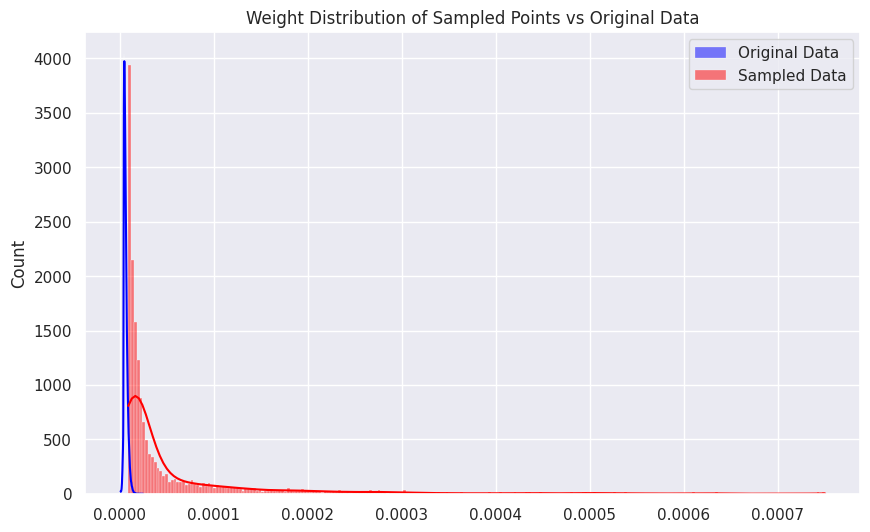

Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.


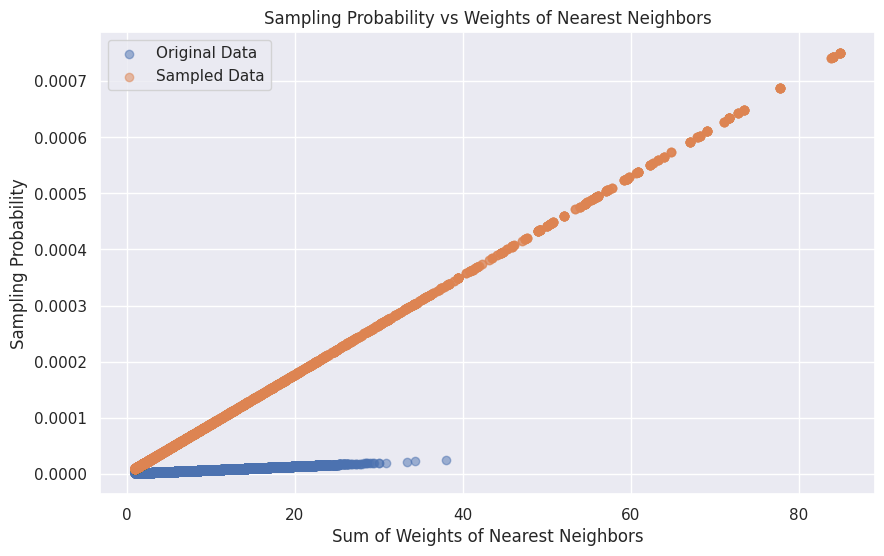

In [116]:
plot_sampling_metrics(adata,adata_samp, feat_use, knn_key)

In [105]:
def plot_class_distribution(adata, adata_samp, feat_use):
    # Determine the number of unique classes
    num_classes = len(adata.obs[feat_use].unique())
    
    # Set the width of the plot to show up to 150 classes comfortably, adjust as needed
    width_per_class = 0.1
    fig_width = max(12, num_classes * width_per_class)
    fig, ax = plt.subplots(1, 2, figsize=(fig_width, 6))
    # If there are fewer than 150 classes, use a bar plot
    if num_classes < 120:
        #adata.obs[feat_use].value_counts().plot(kind='bar', ax=ax[0])#adata.obs[feat_use].value_counts().sort_index().plot(kind='bar', ax=ax[0])
        #adata_samp.obs[feat_use].value_counts().plot(kind='bar', ax=ax[1])#adata_samp.obs[feat_use].value_counts().sort_index().plot(kind='bar', ax=ax[1])
        sns.histplot(adata.obs[feat_use],color='blue', label='Original Data', kde=True, ax=ax[0])
        #adata_samp.obs[feat_use].sort_index().plot(kind='hist', bins=20, ax=ax[1])
        sns.histplot(adata_samp.obs[feat_use], color='red', label='Sampled Data', kde=True,ax=ax[1])
    # Otherwise, use a histogram
    else:
        # Set number of bins
        bins = min(50, num_classes)
        #adata.obs[feat_use].sort_index().plot(kind='hist', bins=20, ax=ax[0])
        sns.histplot(adata.obs[feat_use] , bins=bins,color='blue', label='Original Data', kde=True, ax=ax[0])
        #adata_samp.obs[feat_use].sort_index().plot(kind='hist', bins=20, ax=ax[1])
        sns.histplot(adata_samp.obs[feat_use], bins=bins, color='red', label='Sampled Data', kde=True,ax=ax[1])
    ax[0].set_title('Before Sampling')
    ax[1].set_title('After Sampling')
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

def compute_weights(adata, feat_use, knn_key):
    # Convert string labels to integer labels
    unique_labels, indices = np.unique(adata.obs[feat_use], return_inverse=True)
    adata.obs['int.labels'] = indices

    neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

    # Get indices for each label
    label_indices = {label: np.where(adata.obs['int.labels'] == label)[0] for label in range(len(unique_labels))}

    weights_list = []

    for label in label_indices:
        indices = label_indices[label]
        neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

        same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
        same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

        same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
        different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

        same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
        different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

        # Calculate the ratio of same-label weights to different-label weights
        # Add a small constant in the denominator to avoid division by zero
        weights = same_label_weights+ 1e-8 / (different_label_weights + 1e-8)

        weights_list.extend(weights)
#     weights_list = np.array(weights_list) / np.sum(weights_list)
    return weights_list


def compute_sampling_probabilities(adata, feat_use, knn_key):
    # Calculate weights
    weights = compute_weights(adata, feat_use, knn_key)
    # Normalize weights to probabilities
    sampling_probabilities = weights / np.sum(weights)
    return sampling_probabilities


def plot_sampling_metrics(adata,adata_samp, feat_use, knn_key):
    """
    Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.

    Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.
    """
    # Compute weights for original and sampled data
    adata_weights = compute_weights(adata, feat_use, knn_key=knn_key)
#     adata_probabilities = adata_weights / np.sum(adata_weights)
    adata_samp_weights = compute_weights(adata_samp, feat_use, knn_key=knn_key)
#     adata_samp_probabilities = adata_samp_weights / np.sum(adata_samp_weights)
    plot_class_distribution(adata,adata_samp,feat_use)
    
    # Compute sampling probabilities for original and sampled data
    adata_sampling_probabilities = compute_sampling_probabilities(adata, feat_use, knn_key=knn_key)
    adata_samp_sampling_probabilities = compute_sampling_probabilities(adata_samp, feat_use, knn_key=knn_key)

    
    # Weight Distribution of Sampled Points:
    print("Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.")
    plt.figure(figsize=(10, 6))
    sns.histplot(adata_sampling_probabilities, color='blue', label='Original Data', kde=True)
    sns.histplot(adata_samp_sampling_probabilities, color='red', label='Sampled Data', kde=True)
    plt.title('Weight Distribution of Sampled Points vs Original Data')
    plt.legend()
    plt.show()

    # Sampling Probability and Weight Relationship:
    print("Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.")
    plt.figure(figsize=(10, 6))
    plt.scatter(adata_weights, adata_sampling_probabilities, label='Original Data', alpha=0.5)
    plt.scatter(adata_samp_weights, adata_samp_sampling_probabilities, label='Sampled Data', alpha=0.5)
    plt.xlabel('Sum of Weights of Nearest Neighbors')
    plt.ylabel('Sampling Probability')
    plt.title('Sampling Probability vs Weights of Nearest Neighbors')
    plt.legend()
    plt.show()

/tmp/ipykernel_16658/383834549.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['int.labels'] = indices
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


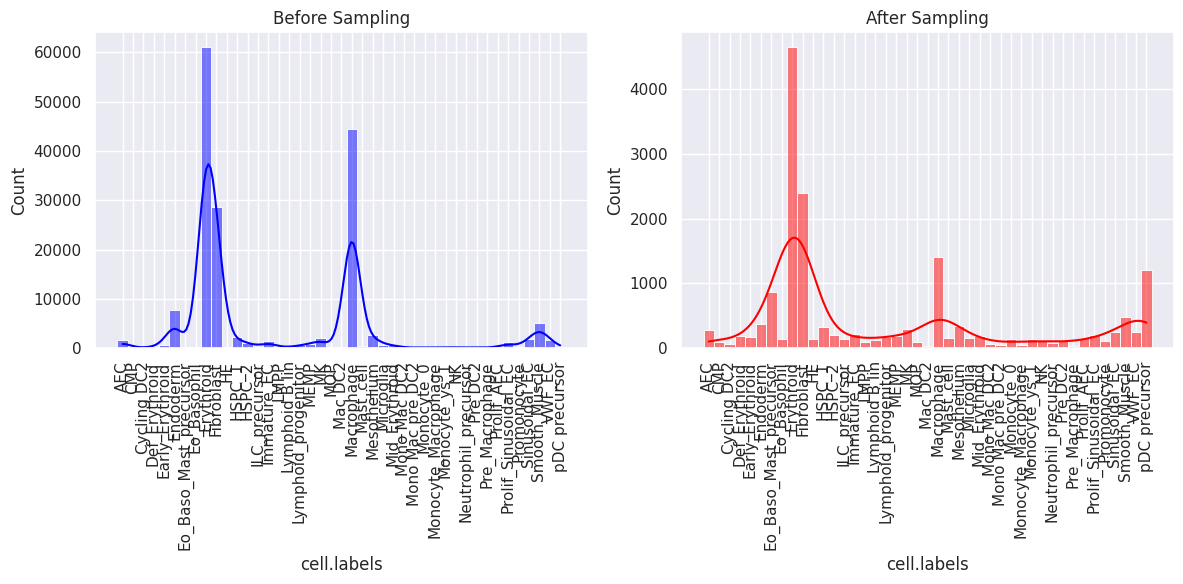

Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.


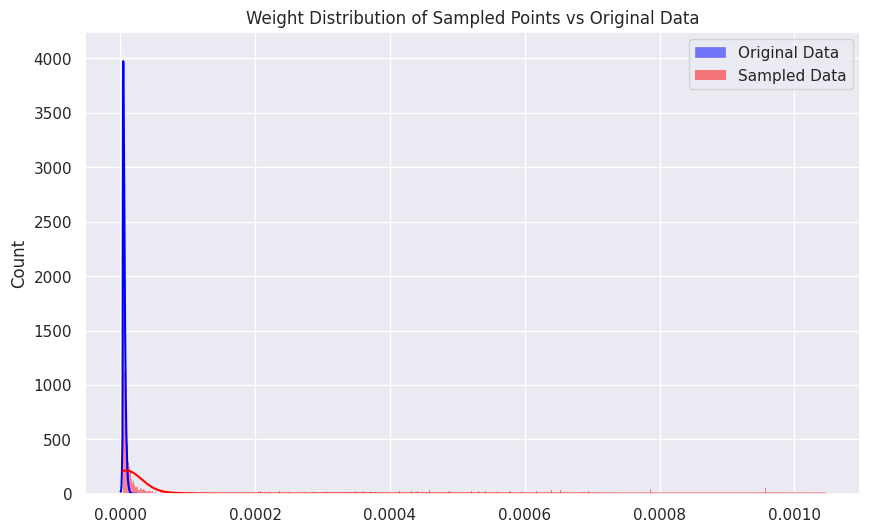

Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.


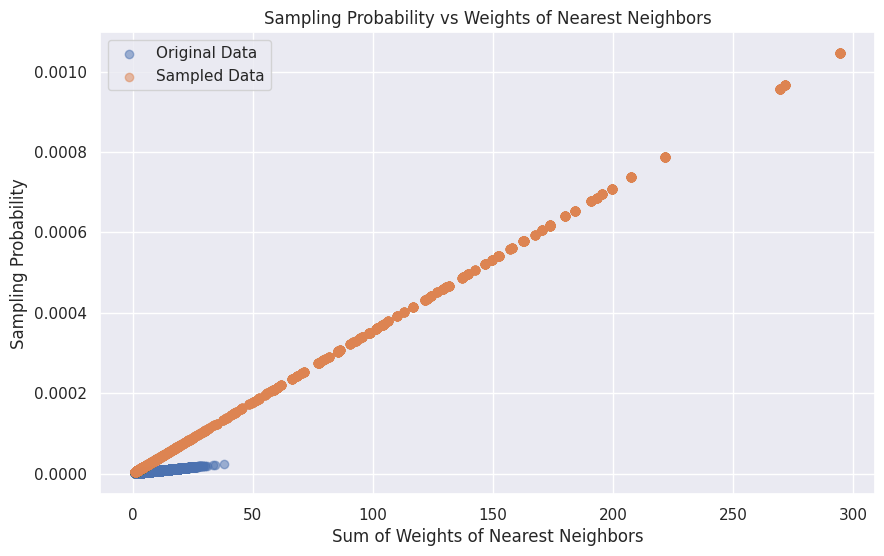

In [106]:
plot_sampling_metrics(adata,adata_samp, feat_use, knn_key)

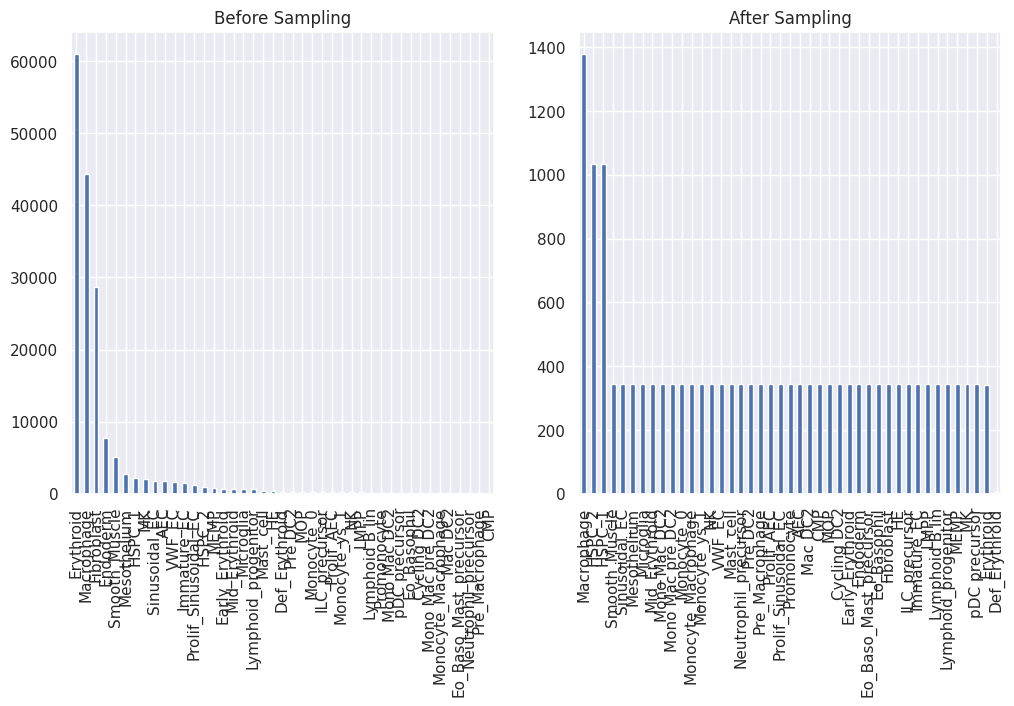

Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.


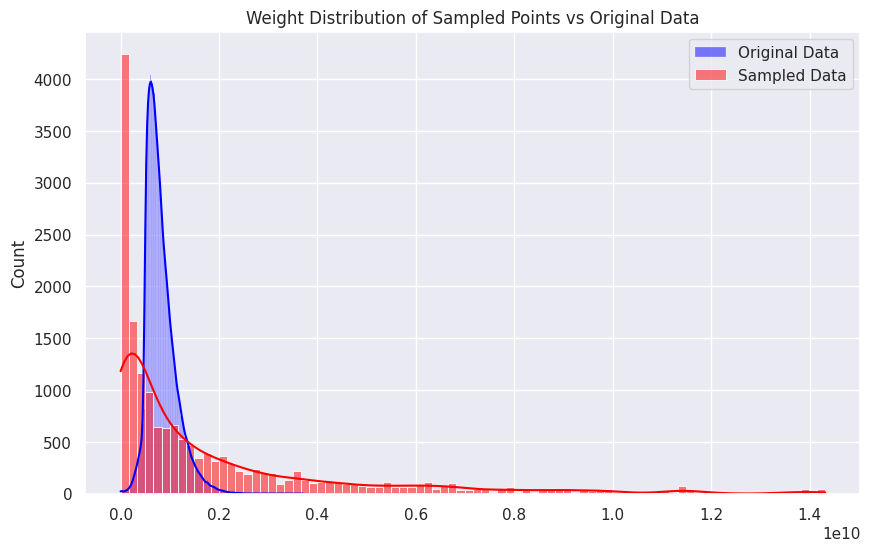

Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.


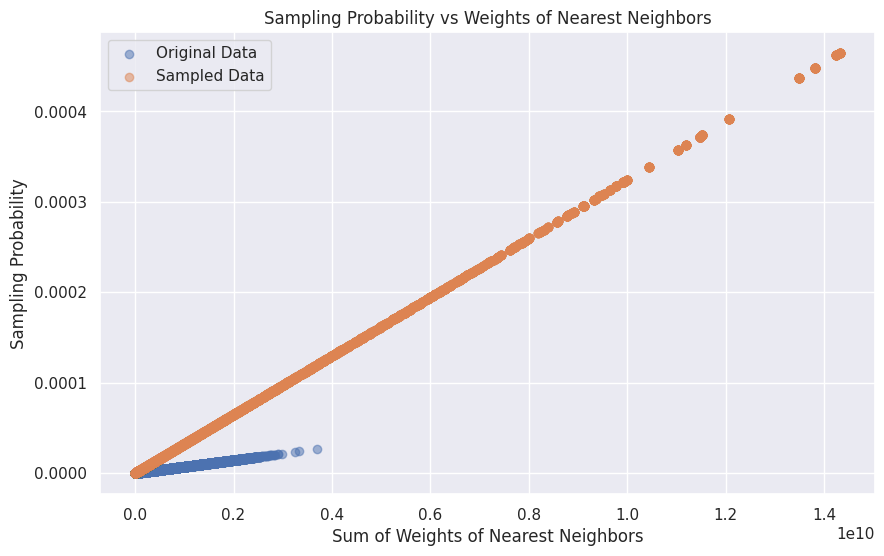

In [45]:
import scipy
import seaborn as sns
def plot_class_distribution(adata, adata_samp, feat_use):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    adata.obs[feat_use].value_counts().plot(kind='bar', ax=ax[0])
    ax[0].set_title('Before Sampling')
    adata_samp.obs[feat_use].value_counts().plot(kind='bar', ax=ax[1])
    ax[1].set_title('After Sampling')
    plt.show()

def compute_weights(adata, feat_use, knn_key):
    # Convert string labels to integer labels
    unique_labels, indices = np.unique(adata.obs[feat_use], return_inverse=True)
    adata.obs['int.labels'] = indices

    neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

    # Get indices for each label
    label_indices = {label: np.where(adata.obs['int.labels'] == label)[0] for label in range(len(unique_labels))}

    weights_list = []

    for label in label_indices:
        indices = label_indices[label]
        neighborhoods = neighborhood_matrix[indices][:, indices]  # select neighborhoods for the current label

        same_label_mask = np.array(adata.obs['int.labels'][indices] == label, dtype=int)  # get mask for same-label cells
        same_label_mask = scipy.sparse.diags(same_label_mask)  # convert to diagonal matrix for multiplication

        same_label_neighborhoods = same_label_mask @ neighborhoods @ same_label_mask  # get neighborhoods of same-label cells
        different_label_neighborhoods = neighborhoods - same_label_neighborhoods  # get neighborhoods of different-label cells

        same_label_weights = np.array(same_label_neighborhoods.sum(axis=1)).ravel()
        different_label_weights = np.array(different_label_neighborhoods.sum(axis=1)).ravel()

        # Calculate the ratio of same-label weights to different-label weights
        # Add a small constant in the denominator to avoid division by zero
        weights = same_label_weights / (different_label_weights + 1e-8)

        weights_list.extend(weights)

    return weights_list


def compute_sampling_probabilities(adata, feat_use, knn_key):
    # Calculate weights
    weights = compute_weights(adata, feat_use, knn_key)
    # Normalize weights to probabilities
    sampling_probabilities = weights / np.sum(weights)
    return sampling_probabilities


def plot_sampling_metrics(adata,adata_samp, feat_use, knn_key):
    """
    Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.

    Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.
    """
    # Compute weights for original and sampled data
    adata_weights = compute_weights(adata, feat_use, knn_key=knn_key)
    adata_samp_weights = compute_weights(adata_samp, feat_use, knn_key=knn_key)
    plot_class_distribution(adata,adata_samp,feat_use)
    # Weight Distribution of Sampled Points:
    print("Weight Distribution of Sampled Points vs Original Data: This histogram compares the weight distribution of your original dataset to your sampled dataset. Weights here represent the sum of connection strengths (weights) of nearest neighbors in the k-nearest neighbors graph. If the sampling strategy is working as intended, you should see that the sampled data's weight distribution is similar to the original data, indicating that the sampling has preserved the relative density of points in the feature space. Large deviations might suggest that the sampling is not preserving the structure of the data well.")
    plt.figure(figsize=(10, 6))
    sns.histplot(adata_weights, color='blue', label='Original Data', kde=True)
    sns.histplot(adata_samp_weights, color='red', label='Sampled Data', kde=True)
    plt.title('Weight Distribution of Sampled Points vs Original Data')
    plt.legend()
    plt.show()

    # Compute sampling probabilities for original and sampled data
    adata_sampling_probabilities = compute_sampling_probabilities(adata, feat_use, knn_key=knn_key)
    adata_samp_sampling_probabilities = compute_sampling_probabilities(adata_samp, feat_use, knn_key=knn_key)

    # Sampling Probability and Weight Relationship:
    print("Sampling Probability vs Weights of Nearest Neighbors: This scatter plot shows the relationship between the weights of nearest neighbors and the sampling probability for each point. Since the sampling probability is proportional to the weight (sum of connection strengths), you expect to see a positive correlation. The sampled data (marked in different color) should follow the same trend as the original data, suggesting that the sampling has preserved the relative importance of points based on their connection strengths.")
    plt.figure(figsize=(10, 6))
    plt.scatter(adata_weights, adata_sampling_probabilities, label='Original Data', alpha=0.5)
    plt.scatter(adata_samp_weights, adata_samp_sampling_probabilities, label='Sampled Data', alpha=0.5)
    plt.xlabel('Sum of Weights of Nearest Neighbors')
    plt.ylabel('Sampling Probability')
    plt.title('Sampling Probability vs Weights of Nearest Neighbors')
    plt.legend()
    plt.show()
    
plot_sampling_metrics(adata,adata_samp,'cell.labels','neighbors')

In [6]:
adata

View of AnnData object with n_obs × n_vars = 16905 × 37318
    obs: 'file', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'cell.labels', 'stage', 'lanes', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pva

# Train the EN model

In [4]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    #adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    #if sample_data_knn != False:
    #    print('Empirical bayes sampling option selected')
    #    adata, indices = scent.empirical_bayes_balanced_stratified_KNN_sampling(adata, use_var, knn_key, sampling_rate= sample_data_knn, iterations=10, equal_allocation=False)
    #print('adata_loaded')
    import time
    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
        adata_temp = adata,
        model_key = model_key + '_lr_model',
        **model_params
        )
        filename =model_name
        pkl.dump(model_trained, open(filename, 'wb'))
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr= model_trained
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata =  scent.load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = scent.load_models(models,model_key)
    model_lr =  model
    
# run with usage logger
import time
t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = scent.reference_projection(adata, model_lr, **model_params)
    if freq_redist != False:
        pred_out['orig_labels'] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out,'orig_labels')
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

{'loss': 'logloss', 'adata_temp': View of AnnData object with n_obs × n_vars = 16905 × 37318
    obs: 'file', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'cell.labels', 'stage', 'lanes', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'sc

100%|██████████| 9/9 [00:00<00:00, 17.79it/s, lam=2, m=156, m_expected=279, probs_dist=(0.00826, 0.03165, 0.002657)] 


starting tuning loops
Fitting 15 folds for each of 1 candidates, totalling 15 fits


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


training complete!
projection time was 1.4248783588409424 seconds
Current memory usage is 6.709353MB; Peak was 51.229398MB
starting memory usage is0
peak CPU % usage = 366.8
peak CPU % usage/core = 14.107692307692307


ValueError: y_true and y_pred contain different number of classes 28, 45. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['CMP' 'DEF_HSPC_1' 'EARLY_ERYTHROID' 'ENDODERM' 'ENDOTHELIUM_PROLIF_AEC'
 'ENDOTHELIUM_SINUSOIDAL' 'EOSINOPHIL_BASOPHIL' 'ERYTHROID' 'HE'
 'IMMATURE_ENDOTHELIUM' 'LYMPHOID B LIN' 'MAC DC2'
 'MACROPHAGE_IRON_RECYCLING' 'MACROPHAGE_KUPFFER_LIKE'
 'MACROPHAGE_MICROGLIA' 'MACROPHAGE_PROLIFERATING' 'MAST_CELL'
 'MESOTHELIUM' 'MID_ERYTHROID' 'MK' 'MONO MAC DC2' 'MONOCYTE_0'
 'MONOCYTE_MACROPHAGE' 'NEUTROPHIL_PRECURSOR' 'NK' 'PRE DC2' 'PROMONOCYTE'
 'unassigned_HSPC_2']

In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs['predicted'].values
scent.report_f1(model_lr,train_x, train_label)

In [ ]:
if train_model == True:
    scent.regression_results(pred_out, 'orig_labels','predicted',list(model_lr.classes_))
else:
    scent.regression_results(pred_out, 'predicted','predicted',list(model_lr.classes_))

import scentinel# View by median probabilities per classification

In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, 'cell.labels', 'predicted')
scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
scent.plot_crosstab_heatmap(adata,  'cell.labels','consensus_clus_prediction')

# View top predictive features per class

In [ ]:
top_loadings

In [ ]:
#Estimate dataset specific feature impact
from matplotlib import pyplot as plt
class_plot = list(model_lr.classes_)[0:3]
for classes in class_plot: #['pDC precursor_ys_HL','AEC_ys_HL']:
    scent.model_class_feature_plots(top_loadings, [str(classes)], 'e^coef','e^coef',20,'top_feat')
    plt.show()

# Save predicted output

In [ ]:
#pred_out.to_csv('./A1_V3_sk_sk_pred_outs.csv')

 # Assess feature impact on model predictions

In [ ]:
top_loadings

10


KeyError: "['weighted_impact'] not in index"

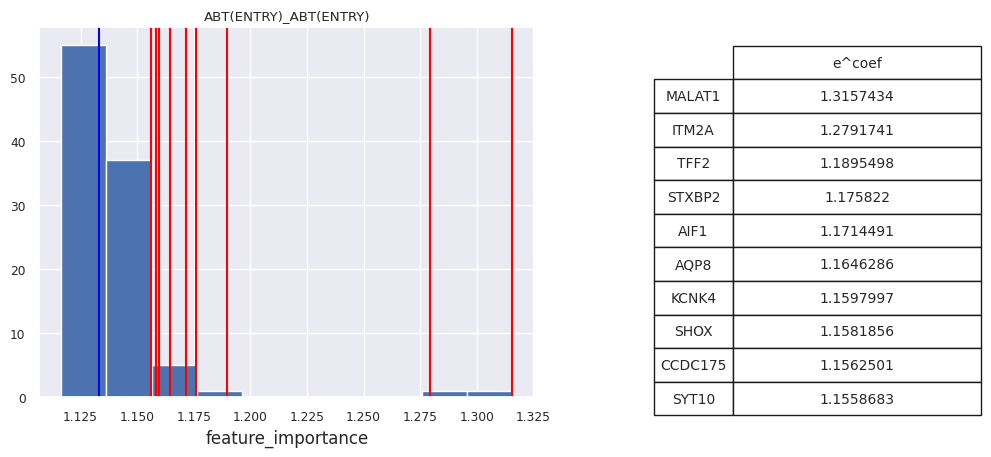

In [26]:
# if using a low-dim model like PCA or ldVAE which has a weights layer
# top_loadings = compute_weighted_impact(varm_file = '/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/A2_V2_ldvae_models/v3_ldvae_obsm_weights.csv',top_loadings =  top_loadings, threshold=0.05)

for class_lin in top_loadings['class'].unique():
    scent.model_class_feature_plots(top_loadings, [class_lin], 'e^coef','e^coef',max_len= 20,title = class_lin)
    scent.analyze_and_plot_feat_gsea(top_loadings,class_lin, max_len=20, pre_ranked=True, database='GO_Biological_Process_2021', cutoff=0.25, min_s=5)

In [27]:
list(top_loadings['class'].unique())

['ABT(ENTRY)',
 'AS_DC',
 'B1',
 'CD4+T',
 'CD8+T',
 'CD8AA',
 'CHONDROCYTE',
 'CMP',
 'CYCLING_B',
 'CYCLING_DC',
 'CYCLING_EPITHELIUM',
 'CYCLING_FIBROBLAST_I',
 'CYCLING_FIBROBLAST_II',
 'CYCLING_ILC',
 'CYCLING_MEMP',
 'CYCLING_MPP',
 'CYCLING_NK',
 'CYCLING_PDC',
 'CYCLING_T',
 'CYCLING_YS_ERY',
 'DC1',
 'DC2',
 'DC_PROGENITOR',
 'DEVELOPING_NEPHRON_I',
 'DEVELOPING_NEPHRON_II',
 'DN(P)_T',
 'DN(Q)_T',
 'DN(early)_T',
 'DOUBLET',
 'DOUBLETS_FIBRO_ERY',
 'DOUBLET_ENDOTHELIUM_ERYTHROCYTE',
 'DOUBLET_ERY_B',
 'DOUBLET_IMMUNE_FIBROBLAST',
 'DOUBLET_LYMPHOID_MACROPHAGE',
 'DOUBLET_VSMC_ERYTHROCYTE',
 'DP(P)_T',
 'DP(Q)_T',
 'EARLY_ERY',
 'EARLY_MK',
 'ENDOTHELIUM_I',
 'ENDOTHELIUM_II',
 'ENDOTHELIUM_III',
 'ENDOTHELIUM_IV',
 'ENDOTHELIUM_V',
 'ENTEROENDOCRINE_I',
 'ENTEROENDOCRINE_II',
 'EOSINOPHIL_BASOPHIL',
 'EPITHELIUM_I',
 'EPITHELIUM_II',
 'FIBROBLAST_I',
 'FIBROBLAST_II',
 'FIBROBLAST_III',
 'FIBROBLAST_IV',
 'FIBROBLAST_IX',
 'FIBROBLAST_V',
 'FIBROBLAST_VI',
 'FIBROBLAST_VII',


In [28]:
top_loadings[top_loadings['class'].isin(['Tip cell (arterial)','HSC','SPP1+ proliferating neuron proneitors'])].groupby(['class']).head(10)

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf


# Let's now run this model in a tansductive format to generalise across across 

# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class
- This is the variable contribution of each feature for a class prediction given a model and data

$X = $$\begin{bmatrix}(e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{n} * g1) + \ (e^{coeff}_{n} * g2) \ +(e^{coeff}_{n} * g3) \ + ..... \end{bmatrix}$

- We measure the model feature effect on class decisoion betwene organs and withi organs
- We can now use these feature availability/impact metrics to compare the availability and differential impact of features between data for transductive and/or inductive runs

In [30]:
df_impact = scent.calculate_feature_distribution(adata, top_loadings, var='predicted')
df_impact

TypeError: calculate_feature_distribution() missing 1 required positional argument: 'top_loadings'

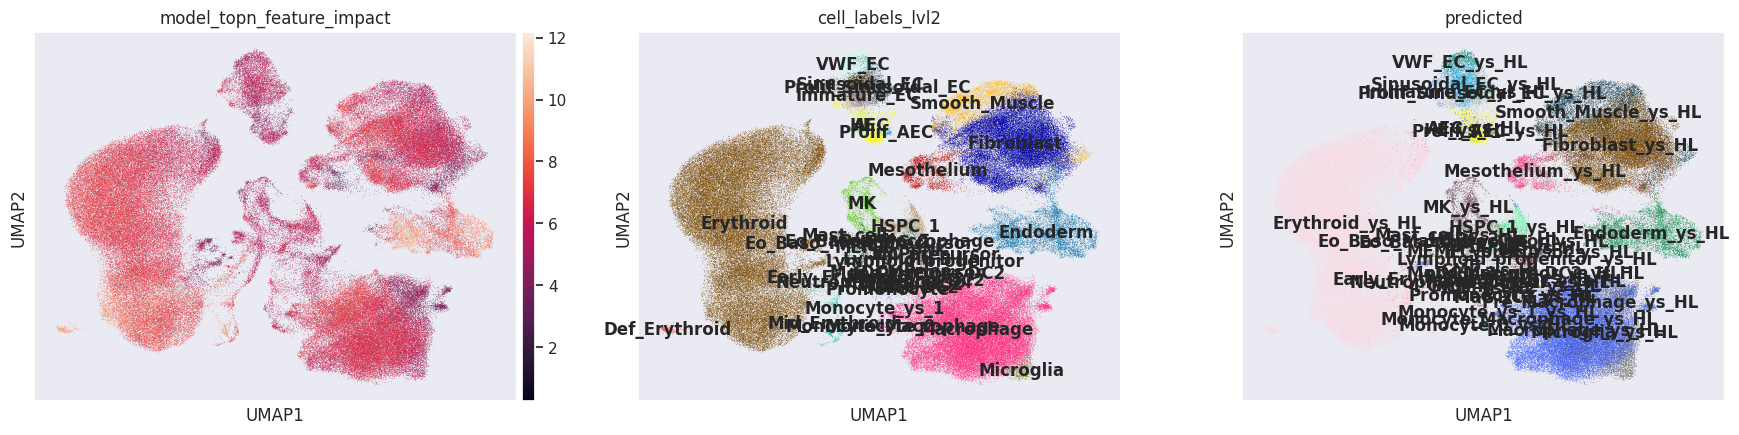

In [18]:
sc.pl.umap(adata_model,color =[ 'model_topn_feature_impact','cell_labels_lvl2','predicted'],legend_loc = 'on data')

# Label stability scoring for individual label performance

In [31]:
# pred_col shape should match the pred_out original labels, so some self-projection works best here
pred_col = list(pred_out.columns[pred_out.columns.isin(set(pred_out['orig_labels']))])
loss, log_losses, weights = scent.compute_label_log_losses(pred_out, 'orig_labels', pred_col)

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [36]:
print('This is our global entropy {}'.format(loss))
print('This is our per-label entropy {}'.format(log_losses))
print('This is our per-label weight {}'.format(weights))

This is our global entropy 24.504262359941666
This is our per-label entropy {'B cell': 0.34397726937068196, 'DC1': 0.10711433040644056, 'DC2': 0.43402919503320114, 'DC precursor': 0.025543967131300128, 'Early Erythroid': 3.820729910479723, 'Early lymphoid_T lymphocyte': 0.24451396256470181, 'Endothelial cell': 1.0673177922641732, 'Fibroblast': 0.5460918094828342, 'HSC_MPP': 0.1534324468272948, 'Hepatocyte': 0.7902869793975166, 'ILC precursor': 0.5502361139330835, 'Kupffer Cell': 7.919128219126143, 'Late Erythroid': 1.0137606270609532, 'MEMP': 0.06365031058941667, 'Mast cell': 0.41698078622507134, 'Megakaryocyte': 1.269751125026345, 'Mid Erythroid': 8.607401550517524, 'Mono-Mac': 2.1008435636263147, 'Monocyte': 0.8243977929495675, 'Monocyte precursor': 0.1115774275067089, 'NK': 0.5238048845241574, 'Neutrophil-myeloid progenitor': 0.2097655637126125, 'Pre pro B cell': 0.07459748010448546, 'VCAM1+ EI macrophage': 0.05132561665308621, 'pDC precursor': 0.08065454045484963, 'pre-B cell': 0.4

# Label confidence scoring, weighted probabilities and label propagation

## Bayesian KNN label stability
For modelling label uncertainty given neighborhood membership and distances

#### Step 1: Generate Binary Neighborhood Membership Matrix
The first step is to generate a binary neighborhood membership matrix from the connectivity matrix. This is done with the function get_binary_neigh_matrix(connectivities), which takes a connectivity matrix as input and outputs a binary matrix indicating whether a cell is a neighbor of another cell.

The connectivity matrix represents the neighborhood relationships between cells, typically obtained from KNN analysis. In this matrix, each row and column represent a cell, and an entry indicates the 'connectivity' between the corresponding cells.

The function transforms the connectivity matrix into a binary matrix by setting all non-zero values to 1, indicating a neighborhood relationship, and all zero values remain as 0, indicating no neighborhood relationship.

#### Step 2: Calculate Label Counts
Next, the function get_label_counts(neigh_matrix, labels) is used to count the number of occurrences of each label in the neighborhood of each cell. The input to this function is the binary neighborhood membership matrix and a list of labels for each cell.

The function returns a matrix in which each row corresponds to a cell, and each column corresponds to a label. Each entry is the count of cells of a particular label in the neighborhood of a given cell.

#### Step 3: Compute Distance-Entropy Product
In the third step, the function compute_dist_entropy_product(neigh_membership, labels, dist_matrix) computes the product of the average neighborhood distance and the entropy of the label distribution in the neighborhood for each cell and each label.

The entropy of a label distribution in a neighborhood is a measure of the diversity or 'mix' of labels in that neighborhood, with higher entropy indicating a more diverse mix of labels. The average neighborhood distance for a cell is the average distance from that cell to all other cells in its neighborhood.

By multiplying the entropy with the average distance, this function captures two important aspects of the neighborhood:

Entropy: The diversity of labels in a neighborhood. High entropy means the neighborhood is a 'melting pot' of many different labels, while low entropy indicates a neighborhood dominated by a single label.
Distance: The spatial proximity of cells in a neighborhood. A high average distance means the cells in a neighborhood are widely dispersed, while a low average distance indicates a compact, closely-knit neighborhood.
Thus, the distance-entropy product for a cell provides a measure of the 'stability' of the cell's label, with lower values indicating a stable, consistent label and higher values indicating an unstable, inconsistent label.

#### Step 4: Bayesian Sampling and Weight Calculation
The final step is the compute_weights function, which uses Bayesian inference to compute a posterior distribution of the distance-entropy product for each label and calculates the weights.

In Bayesian inference, we start with a prior distribution that represents our initial belief about the parameter we're interested in, and we update this belief using observed data to get a posterior distribution.

In this case, the prior distribution is a normal distribution with mean and standard deviation equal to the mean and standard deviation of the distance-entropy product for the original labels. The observed data is the distance-entropy product for the predicted labels. A normal distribution is a reasonable choice for the prior because the distance-entropy product is a continuous variable that can theoretically take on any real value, and the normal distribution is the most common distribution for such variables.

After sampling from the posterior distribution, the weight for each label is calculated as one minus the ratio of the standard deviation of the posterior distribution to the maximum standard deviation across all labels. This means that labels with a larger standard deviation (indicating greater uncertainty about their stability) will have smaller weights, and labels with a smaller standard deviation (indicating less uncertainty) will have larger weights.

The weights are returned as a dictionary where each key-value pair corresponds to a label and its weight.

#### Step 5: Apply Weights to Probabilities
Finally, the weights are applied to the probability dataframe with the function apply_weights(prob_df, weights). The input to this function is a dataframe where each row corresponds to a cell and each column corresponds to a label, with each entry being the probability of the cell being of the label, and a dictionary of weights.

This function multiplies each column of the probability dataframe by the corresponding weight, effectively 'boosting' the probabilities of labels with larger weights and 'penalizing' the probabilities of labels with smaller weights. After applying the weights, the function normalizes the probabilities so that they sum to 1 for each cell, returning a dataframe of the same shape as the input but with the probabilities weighted and normalized.

Overall, this method provides a principled way to quantify label uncertainty and adjust the probabilities output by a logistic regression model accordingly. It combines the strengths of KNN, which can capture local structure and relationships in the data, and Bayesian inference, which provides a robust framework for dealing with uncertainty and incorporating prior knowledge. By weighting the probabilities according to the stability of the labels, this method can potentially improve the accuracy and interpretability of the logistic regression model's predictions.

In [43]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors = 30)

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10

In [76]:
use_rep = 'neighbors'
original_labels_col ='cell.labels'
predicted_labels_col = 'cell.labels'
    

# Extract the necessary data from the anndata object
obs_met = adata.obs
neigh_membership = get_binary_neigh_matrix(adata.obsp[adata.uns[use_rep]['connectivities_key']])
original_labels = obs_met[original_labels_col]
predicted_labels = obs_met[predicted_labels_col]
dist_matrix = adata.obsp[adata.uns[use_rep]['distances_key']]

# Compute the 'distance-entropy' product for each cell and each label
dist_entropy_product = compute_dist_entropy_product(neigh_membership, predicted_labels, dist_matrix)

# Compute the 'distance-entropy' product for the original labels
dist_entropy_product_orig = compute_dist_entropy_product(neigh_membership, original_labels, dist_matrix)

weights = {}
rhat_values = {}
means = []  # Collect all posterior means
sds = []  # Collect all posterior standard deviations
for label in np.unique(predicted_labels):
    print("Sampling {} posterior distribution".format(label))
    # Perform Bayesian inference to compute the posterior distribution of the
    # 'distance-entropy' product for this label
    orig_pos = obs_met[original_labels_col].isin([label])
    pred_pos = obs_met[predicted_labels_col].isin([label])
    with pm.Model() as model:
        #priors
        mu = pm.Normal('mu', mu=dist_entropy_product_orig[orig_pos.values].mean(), sd=dist_entropy_product_orig[orig_pos.values].std())
        sd = pm.HalfNormal('sd', sd=dist_entropy_product_orig[orig_pos.values].std())
        #observations
        obs = pm.Normal('obs', mu=mu, sd=sd, observed=dist_entropy_product_orig[pred_pos.values])

#         if len(orig_pos) > 10000:
#             samp_rate = 0.1
#             smp = int(len(orig_pos)*samp_rate)
#             tne = int((len(orig_pos)*samp_rate)/2)
#             trace = pm.sample(smp, tune=tne)
#         else:
        trace = pm.sample(1000, tune=500)
    # Compute R-hat for this label
    rhat = pm.rhat(trace)
    rhat_values[label] = {var: rhat[var].data for var in rhat.variables}
    # Compute the mean and the standard deviation of the posterior distribution for this label
    mean_posterior = pm.summary(trace)['mean']['mu']
    sd_posterior = pm.summary(trace)['sd']['sd']
    sds.append(sd_posterior)
    means.append(mean_posterior)

# Mean posterior probabilitty models the stability of a label given entropy_distance measures within it's neighborhood
max_mean = max(means)
# SD here models the uncertainty of label entropy_distance measures
max_sd = max(sds)  # Compute the maximum standard deviation

# Compute the weights as the sum of the normalized mean and the normalized standard deviation. This makes each weight relative to each other
# shift all weights up by epiislon constant
epsilon = 0.01
for label, mean, sd in zip(np.unique(predicted_labels), means, sds):
    weights[label] = (1 - mean / max_mean) * (1 - sd / max_sd) + epsilon

Sampling B cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 69 seconds.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc3:There were 457 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not c

Sampling DC precursor posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 72 seconds.
ERROR:pymc3:There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the mod

Sampling DC1 posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 55 seconds.
ERROR:pymc3:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arvi

Sampling DC2 posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
ERROR:pymc3:There were 462 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arvi

Sampling Early Erythroid posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
ERROR:pymc3:There were 473 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:There were 512 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 522 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not u

Sampling Early lymphoid_T lymphocyte posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 32 seconds.
ERROR:pymc3:There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 446 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the mo

Sampling Endothelial cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 73 seconds.
ERROR:pymc3:There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 498 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. 

Sampling Fibroblast posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 58 seconds.
ERROR:pymc3:There were 423 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the mod

Sampling HSC_MPP posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.
ERROR:pymc3:There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release

Sampling Hepatocyte posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 39 seconds.
ERROR:pymc3:There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 516 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 506 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release

Sampling ILC precursor posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 83 seconds.
ERROR:pymc3:There were 437 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 438 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the mo

Sampling Kupffer Cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
ERROR:pymc3:There were 502 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 521 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 481 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release.

Sampling Late Erythroid posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
ERROR:pymc3:There were 255 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model ar

Sampling MEMP posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 43 seconds.
ERROR:pymc3:There were 398 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 523 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 198 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release.

Sampling Mast cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 68 seconds.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:G

Sampling Megakaryocyte posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 114 seconds.
ERROR:pymc3:There were 511 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 468 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the m

Sampling Mid Erythroid posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
ERROR:pymc3:There were 501 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 505 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 477 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release.

Sampling Mono-Mac posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
ERROR:pymc3:There were 307 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using 

Sampling Monocyte posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.
ERROR:pymc3:There were 513 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arv

Sampling Monocyte precursor posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 77 seconds.
ERROR:pymc3:There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arv

Sampling NK posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:There were 494 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 512 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 498 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not u

Sampling Neutrophil-myeloid progenitor posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 56 seconds.
ERROR:pymc3:There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release.

Sampling Pre pro B cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
ERROR:pymc3:There were 249 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 310 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model 

Sampling VCAM1+ EI macrophage posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 55 seconds.
ERROR:pymc3:There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arvi

Sampling pDC precursor posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz

Sampling pre-B cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sd, mu]


INFO:pymc3:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
ERROR:pymc3:There were 389 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 505 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
ERROR:arviz.data.io_pymc3

Sampling pro-B cell posterior distribution


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...

KeyboardInterrupt



In [ ]:
weights = scent.compute_weights(adata,use_rep = 'neighbors', original_labels_col ='consensus_clus_prediction', predicted_labels_col = 'consensus_clus_prediction')
adata.obsm['pred_out'] = pred_out
adata.obsm['pred_out_weighted'] = apply_weights(adata.obsm['pred_out'],weights)

# Optionally now use the updated probabilities for label propagation 

In [403]:
# Here define new labels with the updated probabilities
# Run Freq-redist or 68CI redist amongst neighborhoods or new clusters